In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
# https://beausty23.tistory.com/168

In [2]:
# 별 거 아니지만 이거부터...
import os
os.chdir(r'C:\Users\user\Documents\tensorflow')
os.getcwd()

'C:\\Users\\user\\Documents\\tensorflow'

In [3]:
scicite_builder = tfds.builder('scicite')

In [4]:
(ds_train, ds_val, ds_test), info = tfds.load(
					'scicite',
					split=['train[:90%]', 'train[90%:]', 'test'],
                    as_supervised=True,
                    with_info=True
				)

In [5]:
info

tfds.core.DatasetInfo(
    name='scicite',
    full_name='scicite/1.0.0',
    description="""
    This is a dataset for classifying citation intents in academic papers.
    The main citation intent label for each Json object is specified with the label
    key while the citation context is specified in with a context key. Example:
    
    ```json
    {
     'string': 'In chacma baboons, male-infant relationships can be linked to both
        formation of friendships and paternity success [30,31].'
     'sectionName': 'Introduction',
     'label': 'background',
     'citingPaperId': '7a6b2d4b405439',
     'citedPaperId': '9d1abadc55b5e0',
     ...
     }
    ```
    
    You may obtain the full information about the paper using the provided paper ids
    with the Semantic Scholar API (https://api.semanticscholar.org/).
    
    The labels are: Method, Background, Result
    """,
    homepage='https://github.com/allenai/scicite',
    data_path='C:\\Users\\user\\tensorflow_datasets\\scic

In [6]:
scicite_builder.info.features['label2'].names

['supportive', 'not_supportive', 'cant_determine', 'none']

In [7]:
import io
import os
import shutil
import string

import keras.utils
import tensorflow as tf

from keras import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.layers import TextVectorization

url = "https://s3-us-west-2.amazonaws.com/ai2-s2-research/scicite/scicite.tar.gz"

dataset = keras.utils.get_file("scicite.tar.gz", url, extract=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'scicite')
os.listdir(dataset_dir)

['dev.jsonl', 'scaffolds', 'test.jsonl', 'train.jsonl']

In [8]:
import jsonlines
json_train = list(jsonlines.open(r'scicite/train.jsonl'))

for i in range(5):
    for line in iter(json_train):
        try:
            print(line['label2'] + line['string'])
        except:
            pass

supportiveConsistent with previous reports (al-Khodairy et al., 1995; Seufert et al., 1995; Tanaka et al., 1999; Biggins et al., 2001), our data showed that Smt3 and Ubc9 have pivotal functions during mitosis.
not_supportiveThese results are consistent with field observations of plasma electrolyte concentrations and thermal behaviour of the lizards Sauromalus hispidus and Uromastix acanthinurus (Grenot 1976; Smits 1984) and laboratory observations of S. hispidus (Smits et al. 1986).
not_supportiveMore examples of contradictory results have been observed in bovines; some reports (Zakhartchenko et al., 2001; Bhuiyan et al., 2004) indicated a significant decrease in blastocyst
supportiveThis is in keeping with the report of Blickstein et al,[3,15] which showed that the higher the combined twin birthweight the less likely it was to deliver discordant pairs.
supportive…Lemos et al., 2015) at baseline, allowed for the division of the aMCI group according to an AD-alike pattern of impairment 

In [9]:
# ['supportive', 'not_supportive', 'cant_determine', 'none']

import jsonlines
json_train = list(jsonlines.open(r'scicite/train.jsonl'))

train_supportive = []
train_not_supportive = []
train_cant_determine = []
train_none = []
for line in iter(json_train):
    try:
        if line['label2'] == 'supportive':
            train_supportive.append(line['string'])
        elif line['label2'] == 'not_supportive':
            train_not_supportive.append(line['string'])
        elif line['label2'] == 'cant_determine':
            train_cant_determine.append(line['string'])
        elif line['label2'] == 'none':
            train_none.append(line['string'])
    except:
        pass

# 밑에 두 개는 record가 몇 개 없어서 쓸모가 없고 결국 supportive(356개)냐 not_supportive(471개)냐 하는 긍부정 문제. 근데 이걸 어떻게 학습시킴?


In [10]:
# https://dschloe.github.io/python/tensorflow2.0/ch7_3_sentimentanalysis/

import re

def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    return string.strip() if TREC else string.strip().lower()

In [11]:
# cleansing
train_supportive = [clean_str(i) for i in train_supportive]
train_not_supportive = [clean_str(i) for i in train_not_supportive]

In [12]:
# https://somjang.tistory.com/entry/Keras%EA%B8%B0%EC%82%AC-%EC%A0%9C%EB%AA%A9%EC%9D%84-%EA%B0%80%EC%A7%80%EA%B3%A0-%EA%B8%8D%EC%A0%95-%EB%B6%80%EC%A0%95-%EC%A4%91%EB%A6%BD-%EB%B6%84%EB%A5%98%ED%95%98%EB%8A%94-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EA%B8%B0

# https://favtutor.com/blogs/list-to-dataframe-python

# 각각 데이터프레임을 만들어서 supportive에 1, not_supportive에 -1을 넣고 csv로 저장한 다음 따라가면 긍/부정을 뽑을 수 있을 것같다.
# 더 쉬운 방법도 찾아보면 나오기야 하겠지만 일단은...

In [13]:
import pandas as pd

df = pd.DataFrame(train_supportive, columns=['title'])
df['label'] = 1
df2 = pd.DataFrame(train_not_supportive, columns=['title'])
df2['label'] = -1
train_data = pd.merge(df, df2, how='outer')

<AxesSubplot: >

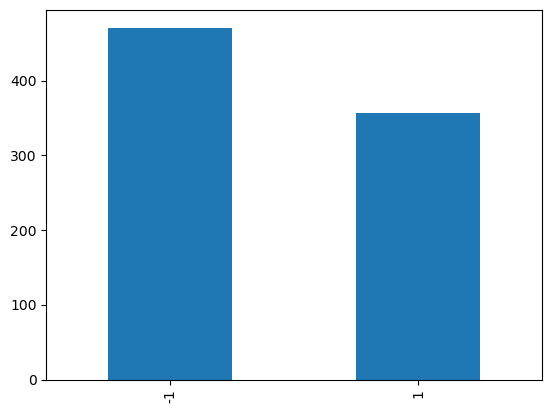

In [14]:
import matplotlib.pyplot as plt
train_data['label'].value_counts().plot(kind='bar')

In [15]:
# 똑같은 짓을 test에도 한다.
# ['supportive', 'not_supportive', 'cant_determine', 'none']

import jsonlines
json_test = list(jsonlines.open(r'scicite/test.jsonl'))

test_supportive = []
test_not_supportive = []
test_cant_determine = []
test_none = []
for line in iter(json_test):
    try:
        if line['label2'] == 'supportive':
            test_supportive.append(line['string'])
        elif line['label2'] == 'not_supportive':
            test_not_supportive.append(line['string'])
        elif line['label2'] == 'cant_determine':
            test_cant_determine.append(line['string'])
        elif line['label2'] == 'none':
            test_none.append(line['string'])
    except:
        pass


In [16]:
# cleansing
test_supportive = [clean_str(i) for i in test_supportive]
test_not_supportive = [clean_str(i) for i in test_not_supportive]

In [17]:
df_test = pd.DataFrame(test_supportive, columns=['title'])
df_test['label'] = 1
df2_test = pd.DataFrame(test_not_supportive, columns=['title'])
df2_test['label'] = -1
test_data = pd.merge(df_test, df2_test, how='outer')

<AxesSubplot: >

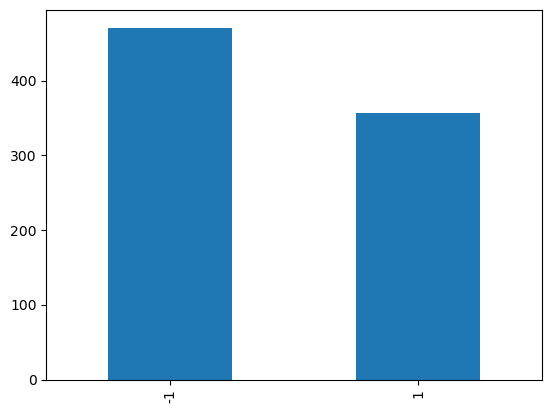

In [18]:
train_data['label'].value_counts().plot(kind='bar')

In [19]:
print(train_data.groupby('label').size().reset_index(name='count'))
print(test_data.groupby('label').size().reset_index(name='count'))

   label  count
0     -1    471
1      1    356
   label  count
0     -1     35
1      1    209


In [20]:
import konlpy
from konlpy.tag import Okt
okt = Okt()
X_train = []
for sentence in train_data['title']:
  temp_X = []
  temp_X = okt.morphs(sentence, stem=True) # 토큰화
  temp_X = [word for word in temp_X]
  X_train.append(temp_X)

X_test = []
for sentence in test_data['title']:
  temp_X = []
  temp_X = okt.morphs(sentence, stem=True) # 토큰화
  temp_X = [word for word in temp_X] # 불용어 제거
  X_test.append(temp_X)

In [21]:
from keras.preprocessing.text import Tokenizer
max_words = 350
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
print(X_train[:3])

[[28, 10, 19, 78, 5, 8, 2464, 9, 8, 1, 125, 1452, 9, 8, 1, 125, 1453, 9, 8, 1, 84, 2465, 9, 8, 1, 69, 6, 1, 17, 70, 60, 13, 2466, 41, 7, 1454, 81, 37, 2467, 1052, 141, 2468], [22, 15, 4, 790, 10, 2, 228, 3, 2469, 9, 8, 1, 41, 1, 119, 31, 60, 13, 2, 92, 2, 1455, 2470, 2471, 2, 244, 344, 82, 33, 12, 2472, 1456, 2473], [1457, 9, 8, 1, 298, 6, 71, 479, 1, 1053, 20, 2, 2474, 3, 2, 1054, 126, 480, 12, 53, 481, 2475, 419, 3, 652, 71, 479, 5, 1457, 9, 8, 1, 298, 6, 1, 7, 33, 171, 10, 2, 245, 3, 791, 12, 481, 4, 653, 299, 16, 5, 2476, 9, 8, 1, 66, 2477, 1, 67, 1055, 9, 8, 1, 66, 6]]


In [23]:
print(X_test[:3])

[[4, 310, 1, 2, 49, 3, 2, 80, 23, 314, 19, 16, 1, 31, 134, 38, 1035, 121, 243, 3, 218, 2831, 679, 172, 564, 10, 5, 122, 1, 188, 1, 180, 6], [2, 19, 185, 1, 7, 24, 160, 1, 83, 48, 35, 12, 2, 751, 3394, 90, 235, 57, 4, 86, 552, 5, 7, 1, 414, 68, 9, 8, 1, 211, 6, 7, 1608, 5, 2971, 7, 1, 697, 1, 357, 7, 3475, 1, 357, 9, 8, 1, 339, 7, 1, 203, 6], [558, 1, 43, 169, 491, 17, 42, 158, 10, 2, 70, 131, 21, 9, 8, 5, 64, 6, 75, 131, 1826, 4, 14, 1594, 35, 12, 2, 80, 23]]


제목의 최대 길이 :  408
제목의 평균 길이 :  43.665054413542926


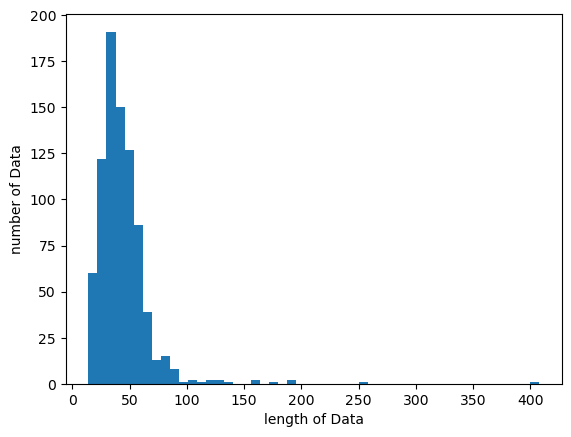

In [24]:
print("제목의 최대 길이 : ", max(len(l) for l in X_train))
print("제목의 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

제목의 최대 길이 :  156
제목의 평균 길이 :  37.84016393442623


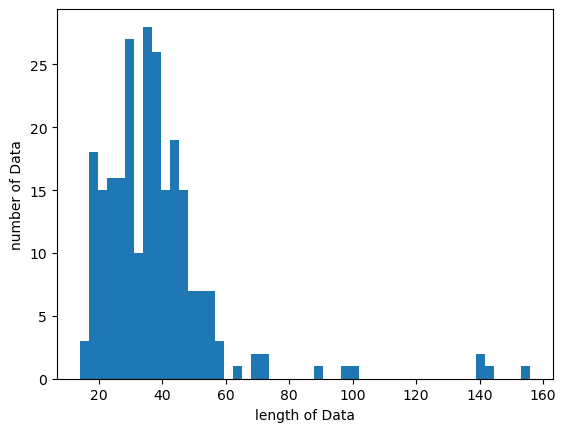

In [25]:
print("제목의 최대 길이 : ", max(len(l) for l in X_test))
print("제목의 평균 길이 : ", sum(map(len, X_test))/ len(X_test))
plt.hist([len(s) for s in X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [26]:
import numpy as np

y_train = []
y_test = []

for i in range(len(train_data['label'])):
  if train_data['label'].iloc[i] == 1:
    y_train.append([0, 1])

  elif train_data['label'].iloc[i] == -1:
    y_train.append([1, 0])

for i in range(len(test_data['label'])):
  if test_data['label'].iloc[i] == 1:
    y_test.append([0, 1])

  elif test_data['label'].iloc[i] == -1:
    y_test.append([1, 0])

y_train = np.array(y_train)
y_test = np.array(y_test)

In [27]:
from keras.layers import Embedding, Dense, LSTM, BatchNormalization, ReLU, PReLU, Dropout
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
max_len = 30 # 전체 데이터의 길이를 20로 맞춘다

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [31]:
import keras.activations
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(BatchNormalization())
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(2, activation='relu'))

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=400, batch_size=80, validation_split=0.001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         35000     
                                                                 
 batch_normalization_1 (Batc  (None, None, 100)        400       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 152,906
Trainable params: 152,706
Non-trainable params: 200
______________________________________________

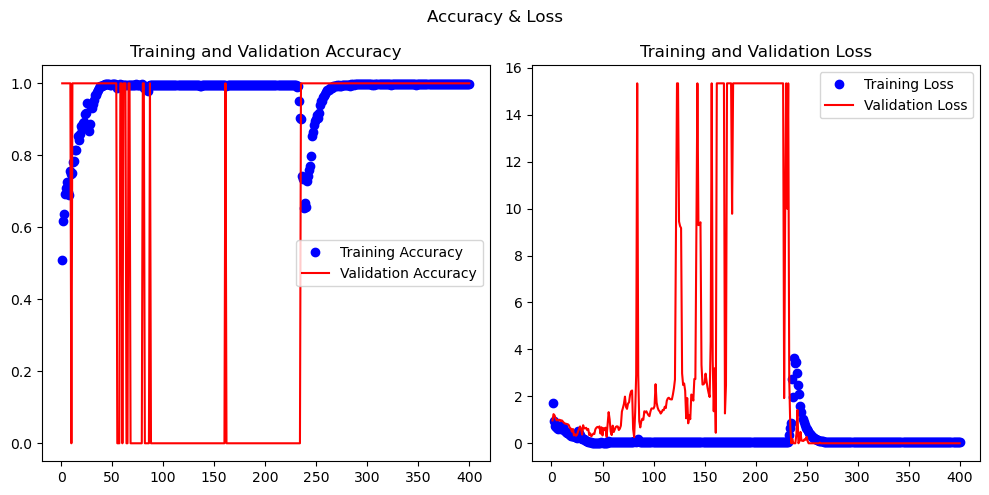

In [32]:
# 훈련 및 검증 정확도, 훈련 및 검증 손실 시각화

# model.fit의 값을 history에 넣었고, 그게 dict형이다. key값이 'acc'인 걸 acc에 담는다. 아래 4줄도 마찬가지고.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epoch을 담고 그 평균을 계산한게 acc인데 거기까지 돈다는 얘기다. 파이썬 특성상 +1 해준 거고.
epochs = range(1, len(acc) + 1)
# ★★ 이거 건져가시면 된다.
# 전체 합친 크기가 (10, 5)라고. 다양하게 바꿔봐라.
plt.figure(figsize=(10, 5))
# 이거도 건져가라.
# plt.subplot(가로, 세로, index)
plt.subplot(1, 2, 1)
# plt.plot(x좌표(epochs = 30), y좌표(이것도 당연히 30))
# 'bo' == 'blue circle'
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.suptitle('Accuracy & Loss')
plt.tight_layout()

plt.show()